# Lesion classification

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2"))

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from IPython.display import Image, display

from libs.isic import load
from libs.auc import calculate_auc
from libs.gradcam import display_gradcam, make_gradcam_heatmap, get_img_array

In [3]:
tf.get_logger().setLevel('ERROR')

## Hyperparameter definition

In [4]:
strategy = tf.distribute.MirroredStrategy()

In [5]:
with strategy.scope():
    EPOCHS = 200
    SAMPLE_NUMBER = None
    
    TARGET_WIDTH, TARGET_HEIGHT = 299, 299
    O_MODEL = tf.keras.applications.mobilenet_v2.MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    RETRAINABLE_LAYERS = []
    LAST_LAYER = 'block_16_project_BN'
    PREPROCESSING = tf.keras.applications.mobilenet_v2.preprocess_input

## Load the ISIC Archive dataset

In [6]:
(training_set, validation_set, testing_set), class_weights, class_number = load(SAMPLE_NUMBER)

/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2/libs/isic/load.py:8: DtypeWarning: Columns (3,11,12,14,15,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")


Found 30286 validated image filenames belonging to 10 classes.
Found 7571 validated image filenames belonging to 10 classes.
Found 4207 validated image filenames belonging to 10 classes.


## Model definition

In [7]:
class LesionClassifier(tf.keras.Model):
    def __init__(self):
        super(LesionClassifier, self).__init__()
        
        self.rescale = tf.keras.layers.Rescaling(scale=1. / 255)
        
        self.o_model = O_MODEL
        for layer in self.o_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
        
        self.dense = tf.keras.layers.Dense(class_number, activation='softmax')
        
    def call(self, inputs):
        o_outputs = self.rescale(inputs)
        o_outputs = self.o_model(o_outputs)

        outputs = self.dense(o_outputs)

        return outputs

In [8]:
checkpoint_path = 'checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

In [9]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=15, 
    restore_best_weights=True
)

In [10]:
time_stopping = tfa.callbacks.TimeStopping(seconds=65 * 3600)

## Training

In [11]:
with strategy.scope():
    model = LesionClassifier()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=EPOCHS,
    callbacks=[
        checkpoint_callback,
        early_stop_callback,
        time_stopping
    ]
)

Epoch 1/200
947/947 [==============================] - ETA: 0s - loss: 0.8071 - accuracy: 0.7315

947/947 [==============================] - 2526s 3s/step - loss: 0.8071 - accuracy: 0.7315 - val_loss: 3.5806 - val_accuracy: 0.6302
Epoch 2/200
947/947 [==============================] - 2366s 2s/step - loss: 0.6978 - accuracy: 0.7598 - val_loss: 4.4874 - val_accuracy: 0.6211
Epoch 3/200
947/947 [==============================] - 2355s 2s/step - loss: 0.6581 - accuracy: 0.7710 - val_loss: 5.0127 - val_accuracy: 0.4162
Epoch 4/200
947/947 [==============================] - ETA: 0s - loss: 0.6310 - accuracy: 0.7803

947/947 [==============================] - 2408s 3s/step - loss: 0.6310 - accuracy: 0.7803 - val_loss: 2.0331 - val_accuracy: 0.5986
Epoch 5/200
947/947 [==============================] - ETA: 0s - loss: 0.6119 - accuracy: 0.7865

947/947 [==============================] - 2384s 3s/step - loss: 0.6119 - accuracy: 0.7865 - val_loss: 1.7029 - val_accuracy: 0.5483
Epoch 6/200
947/947 [==============================] - ETA: 0s - loss: 0.5849 - accuracy: 0.7935

947/947 [==============================] - 2365s 2s/step - loss: 0.5849 - accuracy: 0.7935 - val_loss: 1.1578 - val_accuracy: 0.6941
Epoch 7/200
947/947 [==============================] - ETA: 0s - loss: 0.5673 - accuracy: 0.7995

947/947 [==============================] - 2392s 3s/step - loss: 0.5673 - accuracy: 0.7995 - val_loss: 1.0307 - val_accuracy: 0.7191
Epoch 8/200
947/947 [==============================] - 2328s 2s/step - loss: 0.5572 - accuracy: 0.8019 - val_loss: 1.2315 - val_accuracy: 0.6384
Epoch 9/200
947/947 [==============================] - 2317s 2s/step - loss: 0.5419 - accuracy: 0.8078 - val_loss: 2.1675 - val_accuracy: 0.6080
Epoch 10/200
947/947 [==============================] - ETA: 0s - loss: 0.5303 - accuracy: 0.8120

947/947 [==============================] - 2349s 2s/step - loss: 0.5303 - accuracy: 0.8120 - val_loss: 0.8141 - val_accuracy: 0.7652
Epoch 11/200
947/947 [==============================] - 2334s 2s/step - loss: 0.5185 - accuracy: 0.8157 - val_loss: 0.9166 - val_accuracy: 0.7624
Epoch 12/200
947/947 [==============================] - 2344s 2s/step - loss: 0.5102 - accuracy: 0.8186 - val_loss: 0.8455 - val_accuracy: 0.7259
Epoch 13/200
947/947 [==============================] - 2311s 2s/step - loss: 0.4984 - accuracy: 0.8223 - val_loss: 1.1558 - val_accuracy: 0.7254
Epoch 14/200
947/947 [==============================] - ETA: 0s - loss: 0.4904 - accuracy: 0.8263

947/947 [==============================] - 2341s 2s/step - loss: 0.4904 - accuracy: 0.8263 - val_loss: 0.8092 - val_accuracy: 0.7383
Epoch 15/200
947/947 [==============================] - 2306s 2s/step - loss: 0.4800 - accuracy: 0.8286 - val_loss: 1.2787 - val_accuracy: 0.6059
Epoch 16/200
947/947 [==============================] - 2361s 2s/step - loss: 0.4674 - accuracy: 0.8318 - val_loss: 0.9196 - val_accuracy: 0.7626
Epoch 17/200
947/947 [==============================] - 2304s 2s/step - loss: 0.4634 - accuracy: 0.8337 - val_loss: 1.0319 - val_accuracy: 0.6982
Epoch 18/200
947/947 [==============================] - 2305s 2s/step - loss: 0.4557 - accuracy: 0.8371 - val_loss: 1.2225 - val_accuracy: 0.7270
Epoch 19/200
947/947 [==============================] - ETA: 0s - loss: 0.4483 - accuracy: 0.8401

947/947 [==============================] - 2330s 2s/step - loss: 0.4483 - accuracy: 0.8401 - val_loss: 0.7553 - val_accuracy: 0.7648
Epoch 20/200
947/947 [==============================] - ETA: 0s - loss: 0.4415 - accuracy: 0.8439

947/947 [==============================] - 2325s 2s/step - loss: 0.4415 - accuracy: 0.8439 - val_loss: 0.7152 - val_accuracy: 0.7773
Epoch 21/200
947/947 [==============================] - 2299s 2s/step - loss: 0.4317 - accuracy: 0.8458 - val_loss: 0.9192 - val_accuracy: 0.7541
Epoch 22/200
947/947 [==============================] - 2303s 2s/step - loss: 0.4294 - accuracy: 0.8458 - val_loss: 0.7721 - val_accuracy: 0.7786
Epoch 23/200
947/947 [==============================] - ETA: 0s - loss: 0.4226 - accuracy: 0.8485

947/947 [==============================] - 2329s 2s/step - loss: 0.4226 - accuracy: 0.8485 - val_loss: 0.7141 - val_accuracy: 0.7900
Epoch 24/200
947/947 [==============================] - ETA: 0s - loss: 0.4114 - accuracy: 0.8517

947/947 [==============================] - 2337s 2s/step - loss: 0.4114 - accuracy: 0.8517 - val_loss: 0.6402 - val_accuracy: 0.8012
Epoch 25/200
947/947 [==============================] - 2307s 2s/step - loss: 0.4068 - accuracy: 0.8520 - val_loss: 0.6987 - val_accuracy: 0.8029
Epoch 26/200
947/947 [==============================] - ETA: 0s - loss: 0.4016 - accuracy: 0.8549

947/947 [==============================] - 2325s 2s/step - loss: 0.4016 - accuracy: 0.8549 - val_loss: 0.6036 - val_accuracy: 0.7900
Epoch 27/200
947/947 [==============================] - 2302s 2s/step - loss: 0.3957 - accuracy: 0.8565 - val_loss: 0.8082 - val_accuracy: 0.7397
Epoch 28/200
947/947 [==============================] - 2300s 2s/step - loss: 0.3924 - accuracy: 0.8581 - val_loss: 0.7479 - val_accuracy: 0.7719
Epoch 29/200
947/947 [==============================] - 2297s 2s/step - loss: 0.3812 - accuracy: 0.8637 - val_loss: 1.0539 - val_accuracy: 0.7012
Epoch 30/200
947/947 [==============================] - 2306s 2s/step - loss: 0.3751 - accuracy: 0.8630 - val_loss: 0.6422 - val_accuracy: 0.8033
Epoch 31/200
947/947 [==============================] - ETA: 0s - loss: 0.3741 - accuracy: 0.8651

947/947 [==============================] - 2331s 2s/step - loss: 0.3741 - accuracy: 0.8651 - val_loss: 0.5607 - val_accuracy: 0.8134
Epoch 32/200
947/947 [==============================] - 2302s 2s/step - loss: 0.3669 - accuracy: 0.8682 - val_loss: 0.8741 - val_accuracy: 0.7710
Epoch 33/200
947/947 [==============================] - 2301s 2s/step - loss: 0.3638 - accuracy: 0.8673 - val_loss: 0.6772 - val_accuracy: 0.8107
Epoch 34/200
947/947 [==============================] - 2304s 2s/step - loss: 0.3578 - accuracy: 0.8710 - val_loss: 0.7117 - val_accuracy: 0.7850
Epoch 35/200
947/947 [==============================] - 2305s 2s/step - loss: 0.3530 - accuracy: 0.8715 - val_loss: 0.9612 - val_accuracy: 0.7472
Epoch 36/200
947/947 [==============================] - 2301s 2s/step - loss: 0.3446 - accuracy: 0.8752 - val_loss: 1.1182 - val_accuracy: 0.7793
Epoch 37/200
947/947 [==============================] - 2304s 2s/step - loss: 0.3425 - accuracy: 0.8742 - val_loss: 0.7151 - val_accuracy

947/947 [==============================] - 2416s 3s/step - loss: 0.3109 - accuracy: 0.8865 - val_loss: 0.5571 - val_accuracy: 0.8262
Epoch 44/200
947/947 [==============================] - 2397s 3s/step - loss: 0.3103 - accuracy: 0.8859 - val_loss: 1.2750 - val_accuracy: 0.6804
Epoch 45/200
947/947 [==============================] - 2412s 3s/step - loss: 0.3058 - accuracy: 0.8876 - val_loss: 1.0575 - val_accuracy: 0.7406
Epoch 46/200
947/947 [==============================] - 2387s 3s/step - loss: 0.3030 - accuracy: 0.8880 - val_loss: 0.7882 - val_accuracy: 0.7621


## Testing

In [13]:
model.load_weights(checkpoint_path)

In [14]:
groundtruth_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [15]:
predicted_labels = model.predict(testing_set)

132/132 [==============================] - 253s 2s/step


In [16]:
fpr, tpr, auc_metric = calculate_auc(testing_set, groundtruth_labels, predicted_labels)

In [17]:
auc_metric

{'actinic keratosis': 0.9653226459396,
 'basal cell carcinoma': 0.9833914068872576,
 'dermatofibroma': 0.9645052677310741,
 'melanoma': 0.9346953311239026,
 'nevus': 0.9586200502437251,
 'pigmented benign keratosis': 0.9796349762837698,
 'seborrheic keratosis': 0.9405142722340174,
 'solar lentigo': 0.9217649239896182,
 'squamous cell carcinoma': 0.9738612032754196,
 'vascular lesion': 0.9984062475097618}

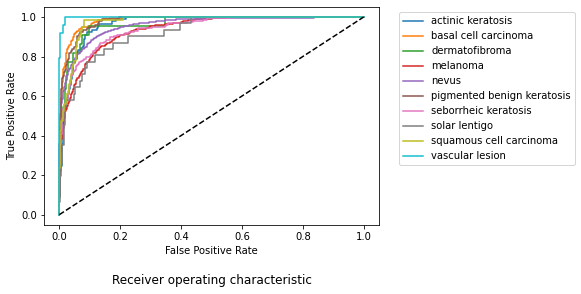

In [18]:
%matplotlib inline 

plt.rcParams['axes.titley'] = -0.3

for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right")
plt.show()

## GradCam

In [19]:
melanoma_im_path = f"{os.environ['SCRATCH']}/isic-archive/ISIC_0000031.jpg"

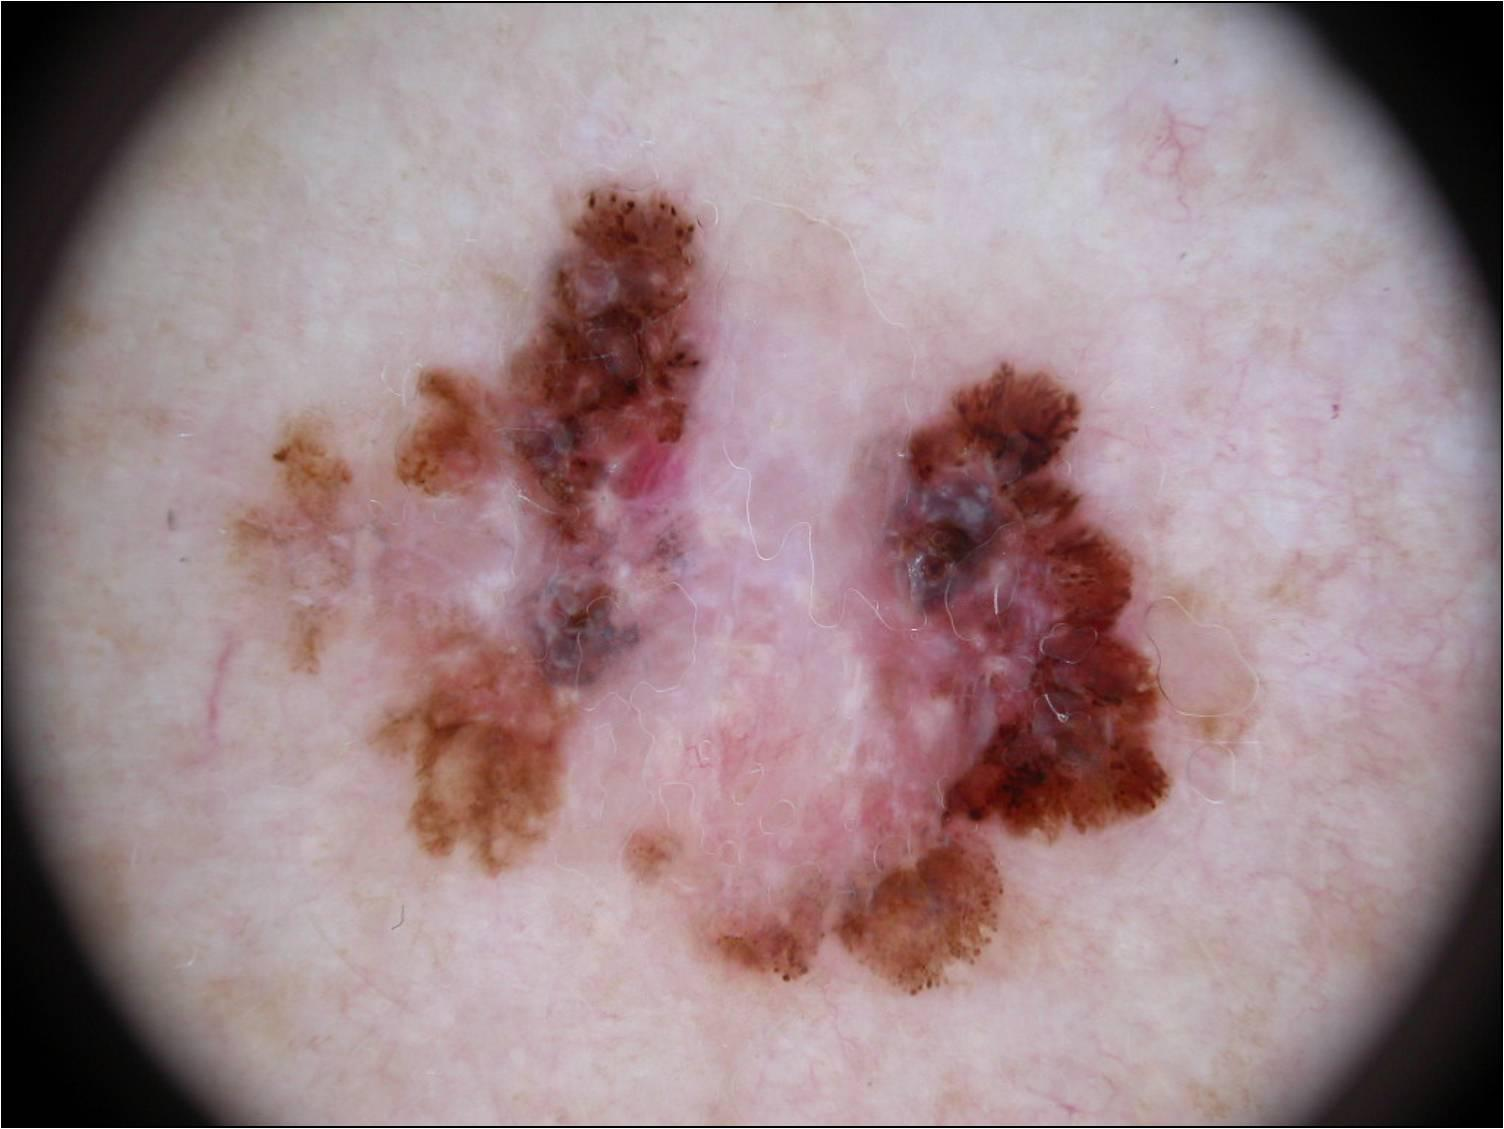

In [20]:
display(Image(melanoma_im_path, width=600))

In [21]:
img_array = PREPROCESSING(get_img_array(melanoma_im_path, size=(299, 299)))

In [22]:
heatmap = make_gradcam_heatmap(img_array, model.o_model, LAST_LAYER)

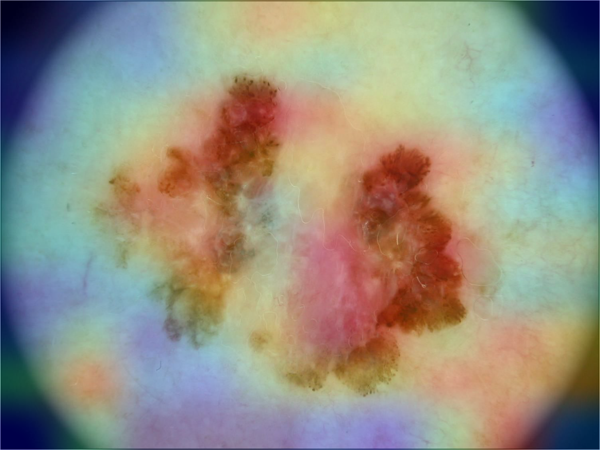

In [23]:
display_gradcam(melanoma_im_path, heatmap)